In [6]:
############################################################################
################       █████   █████████  ███████████       ################ 
################      ░░███   ███░░░░░███░█░░░███░░░█       ################ 
################       ░███  ███     ░░░ ░   ░███  ░        ################ 
################       ░███ ░███             ░███           ################ 
################       ░███ ░███             ░███           ################ 
################       ░███ ░░███     ███    ░███           ################ 
################       █████ ░░█████████     █████          ################ 
################       ░░░░░   ░░░░░░░░░     ░░░░░          ################ 
############################################################################
########                IRI PROGRESSION MODEL (MPEDG)             ##########
################           Project: R27-252 EV             #################
########     Originally written by: Aravind Ramakhrishnan        ###########
############################################################################

# Created on Sat May 28 21:10:59 2022
# Last modified on Fri Jul 27 9:10:59 2024
# @author: Johann-Cardenas

In [2]:
# Import libraries
import os
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize

# Start time tracker
start = time.time()

### **Real IRI Data**

In [8]:
user = 'johan'
path = "C:/Users/" + user + "/Box/R27-252 EV/Tasks/Task 5 - LCCA and LCA/IRI/Data from John Senger/"

# Full-Depth Data
file_name = 'Full Depth Road History 049  20352 000000 22.77 to 23.15.csv'  
file_path = os.path.join(path, file_name)

FDH_Data = pd.read_csv(
    file_path,
    sep=',',
    nrows=11  # Rows 1 to 11 (including header)
)

# Interstate Highway Data (I-57)
file_name = 'I-57 Road History 100  10057 000000 6.85 to 7.25.csv'  # Adjusted file name (single space)
file_path = os.path.join(path, file_name)

ISH_Data = pd.read_csv(
    file_path,
    sep=',',
    nrows=16  # Rows 1 to 16 (including header)
)

# Typical Thick Road Data
file_name = 'Typical Thick Road History 029  20317A000000 21.87 to 22.csv'  # Adjusted file name (single space)
file_path = os.path.join(path, file_name)

TTH_Data = pd.read_csv(
    file_path,
    sep=',',
    nrows=12  # Rows 1 to 12 (including header)
)

When running the cell below, make sure Latex is enabled. Might require to be run at least twice.

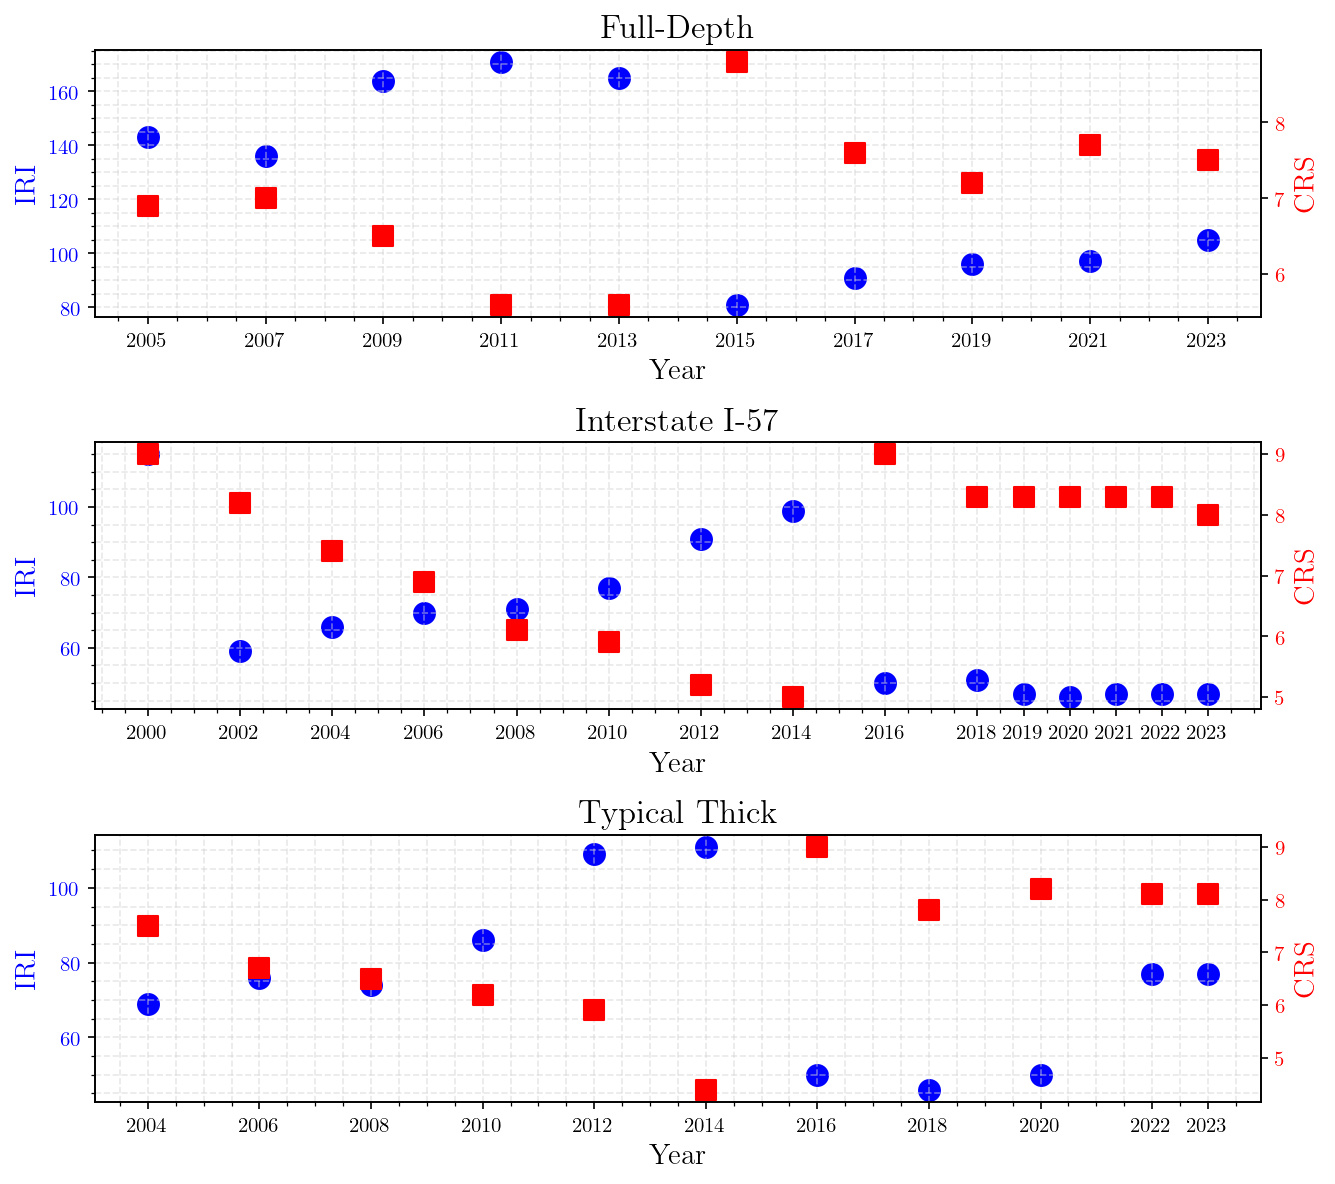

In [9]:
# Plot collected data
fig, axes = plt.subplots(3, 1, figsize=(9, 8), dpi=150, sharex=False)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

datasets = [
    (FDH_Data, 'Full-Depth'),
    (ISH_Data, 'Interstate I-57'),
    (TTH_Data, 'Typical Thick')
]

for ax, (data, title) in zip(axes, datasets):
    data = data.dropna(subset=[' Year', ' IRI WITH', ' CRS WITH'])
    data[' Year'] = data[' Year'].astype(int)
    
    # Primary Y-axis
    ax.scatter(
        data[' Year'],
        data[' IRI WITH'],
        color='blue',
        marker='o',
        s = 100,
        label='IRI'
    )
    ax.set_xlabel('Year', fontsize = 14)
    ax.set_ylabel('IRI', fontsize = 14, color='blue')
    ax.tick_params(axis='y', labelcolor='blue')

    ax.tick_params(axis='x', which='both', labelbottom=True)

    # Secondary Y-axis
    ax2 = ax.twinx()
    ax2.scatter(
        data[' Year'],
        data[' CRS WITH'],
        color='red',
        marker='s',
        s = 100,
        label='CRS'
    )
    ax2.set_ylabel('CRS', fontsize = 14, color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    ax.set_xticks(data[' Year'])
    ax.set_xticklabels(data[' Year'])
    
    ax.grid(which='both', linestyle='--', color='lightgrey', alpha=0.5)
    ax.minorticks_on()
    ax.set_title(title, fontsize = 16)

plt.tight_layout()
plt.show()

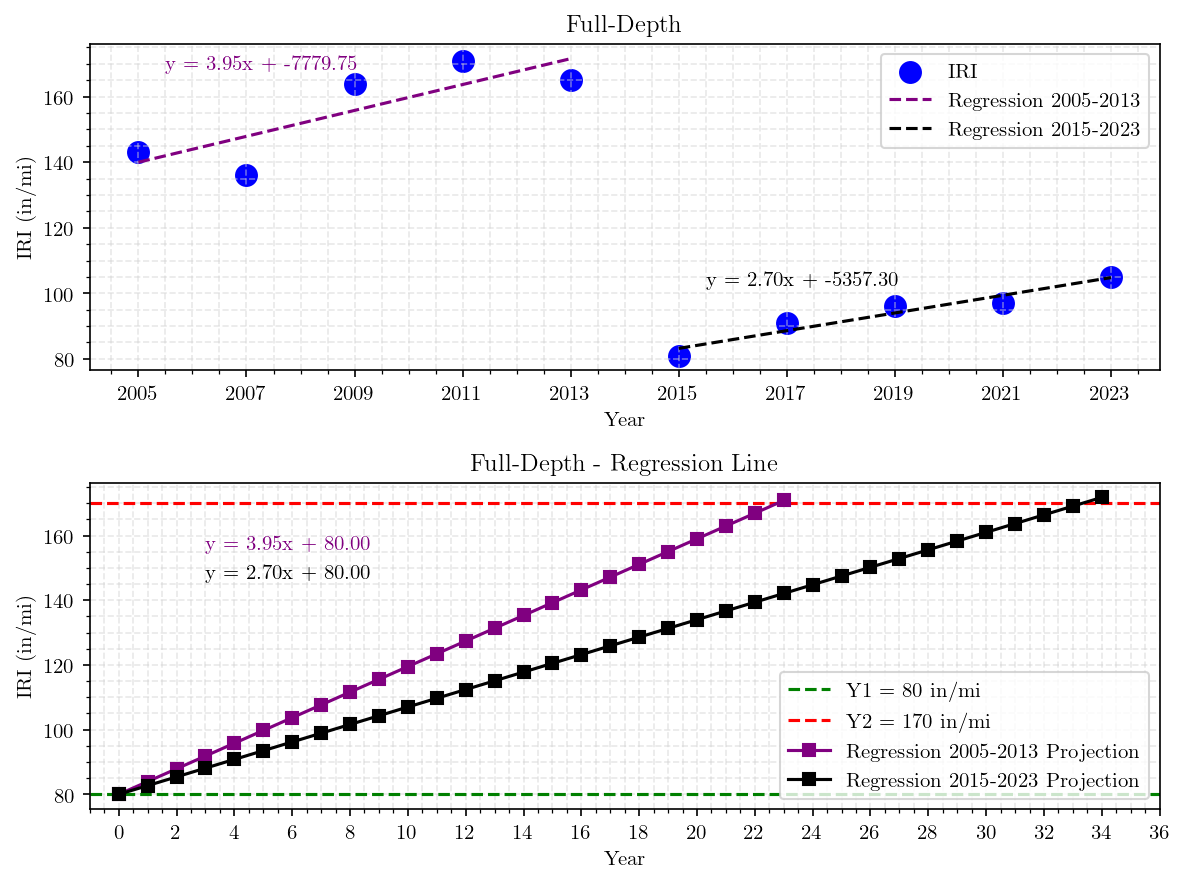

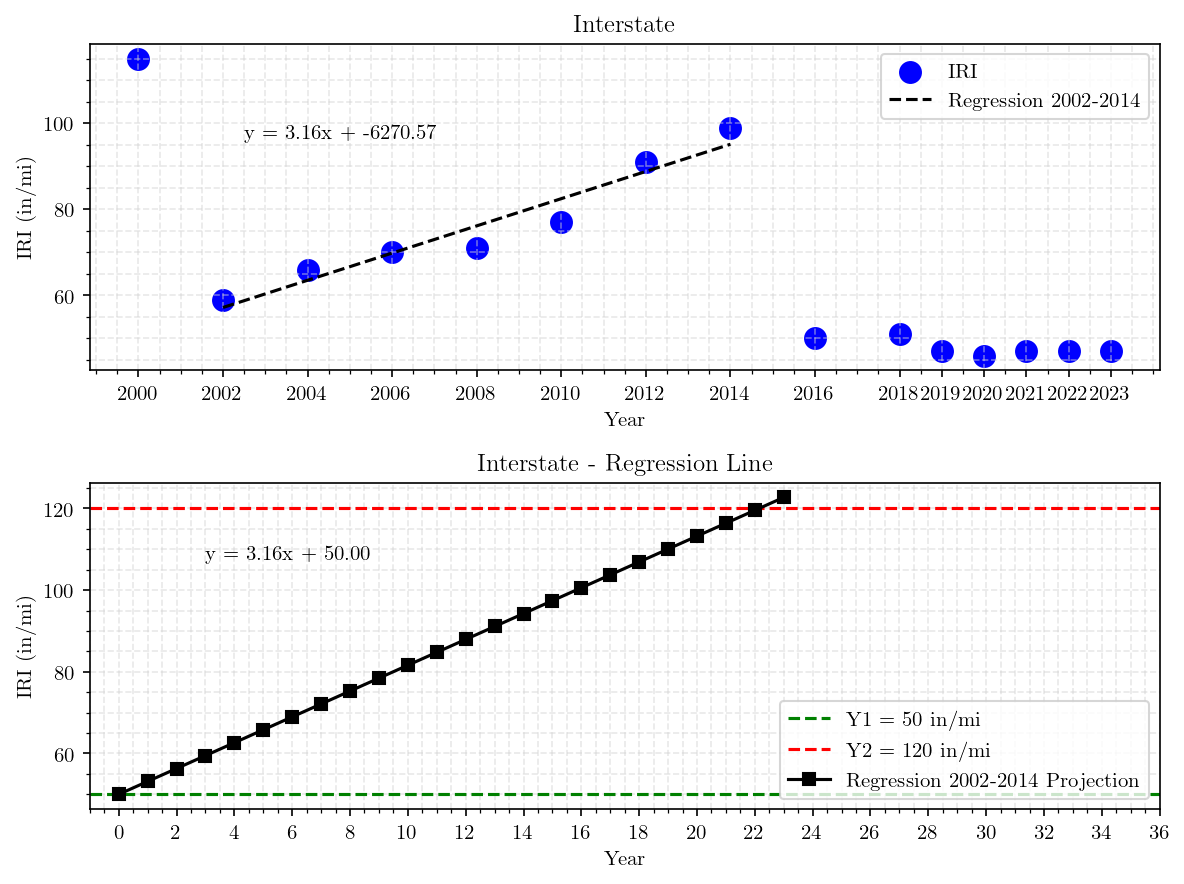

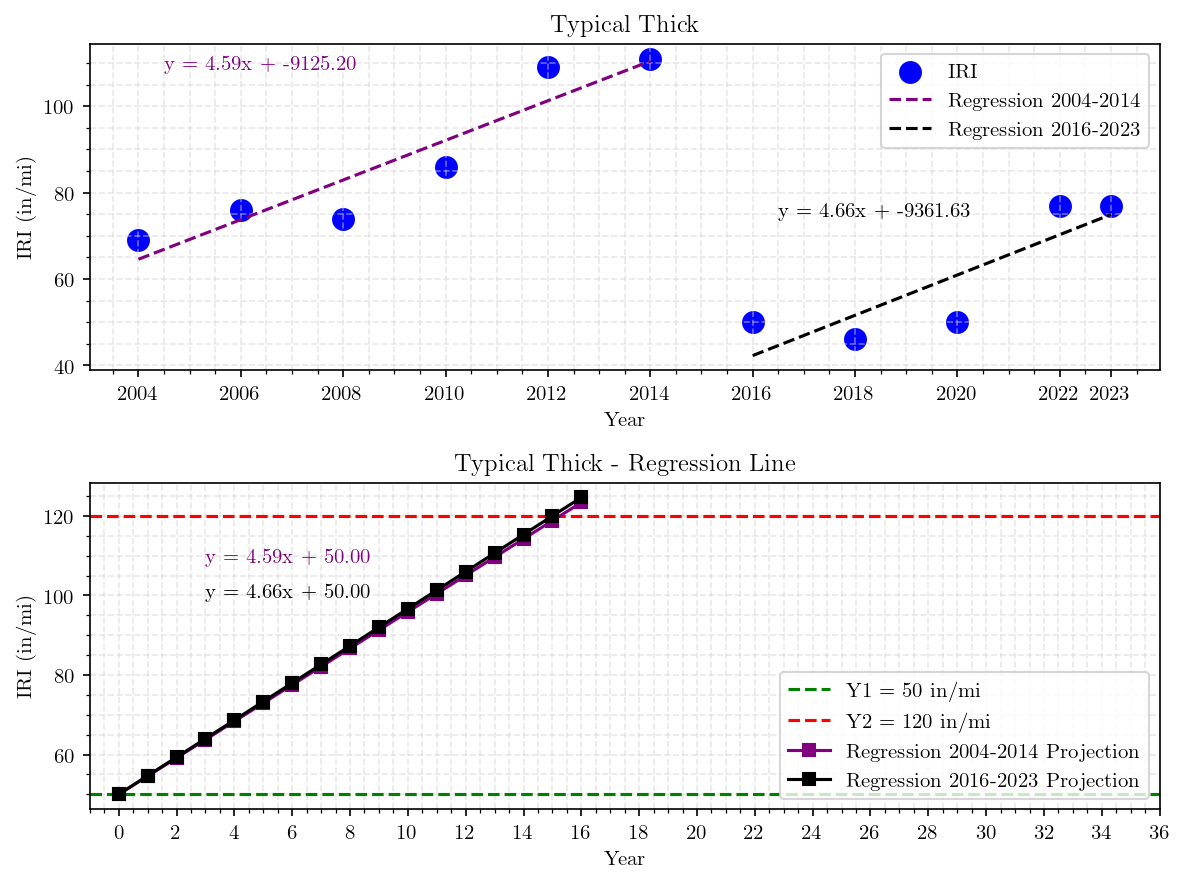

In [10]:
# Regression Lines
datasets = [
    (FDH_Data, 'Full-Depth'),
    (ISH_Data, 'Interstate'),
    (TTH_Data, 'Typical Thick')
]

input_parameters = {
    'Full-Depth': {
        'X1': 0,  # Provided starting year
        'Y1': 80,   # Provided starting IRI value
        'Y2': 170    # Provided threshold IRI value
    },
    'Interstate': {
        'X1': 0,
        'Y1': 50,
        'Y2': 120
    },
    'Typical Thick': {
        'X1': 0,
        'Y1': 50,
        'Y2': 120
    }
}

xticks_range = np.arange(0, 38, 2)

for data, title in datasets:
    # Ensure the data has no missing values in the required columns
    data = data.dropna(subset=[' Year', ' IRI WITH', ' CRS WITH'])
    data[' Year'] = data[' Year'].astype(int)
    data[' IRI WITH'] = data[' IRI WITH'].astype(float)

    
    fig, axs = plt.subplots(2, 1, figsize=(8, 6), dpi=150)
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    
    ax1 = axs[0]

    ax1.scatter(
        data[' Year'],
        data[' IRI WITH'],
        color='blue',
        marker='o',
        s=100,
        label='IRI'
    )
    
    ax1.set_xlabel('Year')
    ax1.set_ylabel('IRI (in/mi)', color='black')
    ax1.tick_params(axis='y', labelcolor='black')

    ax1.set_xticks(data[' Year'])
    ax1.grid(which='both', linestyle='--', color='lightgrey', alpha=0.5)
    ax1.minorticks_on()
    ax1.set_title(title)

    # Second subplot
    ax2 = axs[1]
    ax2.set_xlabel('Year')
    ax2.set_ylabel('IRI (in/mi)')
    ax2.set_title(f"{title} - Regression Line")
    ax2.grid(which='both', linestyle='--', color='lightgrey', alpha=0.5)
    ax2.minorticks_on()
    
    
    stored_coordinates = []
    
    # Store x,y coordinates
    X1_input = input_parameters[title]['X1']
    Y1_input = input_parameters[title]['Y1']
    Y2_input = input_parameters[title]['Y2']
    
    ax2.axhline(Y1_input, color='green', linestyle='--', label=f'Y1 = {Y1_input} in/mi')
    ax2.axhline(Y2_input, color='red', linestyle='--', label=f'Y2 = {Y2_input} in/mi')
    
    # Regression Lines
    
    if title == 'Full-Depth':
        # Regression periods
        periods = [
            {'label': 'Regression 2005-2013', 'color': 'purple', 'years': (2005, 2013)},
            {'label': 'Regression 2015-2023', 'color': 'black', 'years': (2015, 2023)}
        ]
    elif title == 'Interstate':
        periods = [
            {'label': 'Regression 2002-2014', 'color': 'black', 'years': (2002, 2014)}
        ]
    elif title == 'Typical Thick':
        periods = [
            {'label': 'Regression 2004-2014', 'color': 'purple', 'years': (2004, 2014)},
            {'label': 'Regression 2016-2023', 'color': 'black', 'years': (2016, 2023)}
        ]
    
    for idx, period in enumerate(periods):
        # Subset data for regression period
        start_year, end_year = period['years']
        period_data = data[(data[' Year'] >= start_year) & (data[' Year'] <= end_year)]
        x = period_data[' Year']
        y = period_data[' IRI WITH']

        if not x.empty:
            # Perform linear regression
            coeffs = np.polyfit(x, y, 1)
            slope=coeffs[0]
            intercept = coeffs[1]
            equation = f"y = {slope:.2f}x + {intercept:.2f}"
            
    
            # Regression line for original data
            x_line = np.linspace(x.min(), x.max(), 100)
            y_line = slope * x_line + intercept
            ax1.plot(x_line, y_line, color=period['color'], linestyle='--', label=period['label'])
            ax1.text(x.min() + 0.5, y.max() - 2.5, equation, color=period['color'], fontsize=10)
            
            # For the second subplot, use provided X1 and Y1
            X1 = X1_input
            Y1 = Y1_input
            Y2 = Y2_input
            
            intercept_adjusted = Y1 - slope * X1

            if slope != 0:
                # Calculate X2 using the regression equation
                X2 = (Y2 - intercept_adjusted) / slope
                X2 = int(np.ceil(X2))
                # Generate integer X values from X1 to X2
                X_values = np.arange(int(X1), X2 + 1)
                # Calculate Y values using regression equation
                Y_values = slope * X_values + intercept_adjusted
                stored_coordinates.append((X_values, Y_values))
                ax2.plot(X_values, Y_values, color=period['color'], linestyle='-', marker='s', label=f"{period['label']} Projection")
                
                y_offset = 15 if idx%2 ==0 else 25
                equation_projection = f"y = {slope:.2f}x + {intercept_adjusted:.2f}"
                ax2.text(X1 + 3, Y_values.max() - y_offset, equation_projection, color=period['color'], fontsize=10)
                
            else:
                print(f"Slope is zero for {period['label']}, cannot compute X2.")
        else:
            print(f"No data available for {period['label']}.")

    ax1.legend()
    ax2.legend(loc='lower right')
    
    ax2.set_xticks(xticks_range)
    ax2.set_xticklabels(xticks_range, ha='center')
    ax2.set_xlim([-1, 36])

    plt.tight_layout()
    plt.show()

### **Traffic Growth (ESALs)**

In [11]:
def calculate_ESALs_y(ADT, T, T_f, r, y, D, L, N_days):
    ESALs_annual = []
    for year in range(1, y + 1):
        # Traffic growth factor
        G = (1 + r) ** year
        # ESALs for each category (weekday, weekend, holiday)
        ESALs = int(np.sum(ADT * T * T_f * G * D * L * N_days))
        ESALs_annual.append(ESALs)
    return ESALs_annual


def calculate_ESALs(ADT, T, T_f, r, y, D, L, N_days):
    ESALs_monthly = []
    G_monthly = (1 + r) ** (1 / 12)
    
    for year in range(1, y + 1):
        for month in range(1, 13):
            # Traffic growth factor for the current month
            G = G_monthly ** ((year - 1) * 12 + month)
            # Calculate ESALs for the current month
            ESALs = np.sum(ADT * T * T_f * G * D * L * (N_days))
            ESALs_monthly.append(ESALs)
    return ESALs_monthly


T_f = 0.38           # truck factor
r = 0.02             # growth rate
y = 50               # number of years
D = 0.50             # direction factor for two-way traffic
L = 1.00             # lane distribution factor

# Combine inputs into arrays
ADT = np.array([13500, 13500, 13500])  ## [ weekday, weekend, holiday]
T = np.array([0.0456, 0.0456, 0.0456])  ## [ weekday, weekend, holiday]
N_days = np.array([201, 152, 13]) ## [ weekday, weekend, holiday]

# Calculate ESALs
ESALs_yearly = calculate_ESALs_y(ADT, T, T_f, r, y, D, L, N_days)

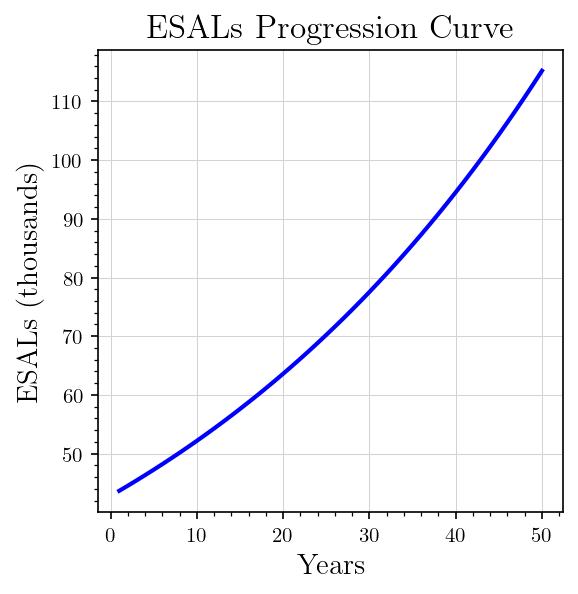

In [12]:
# Plot years vs ESAL progression
fig = plt.figure(figsize=(4, 4), dpi=150)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.plot(range(1, y + 1), np.array(ESALs_yearly)/1e03, color='blue', linewidth=2.0)
plt.xlabel('Years', fontsize = 14)
plt.ylabel('ESALs (thousands)', fontsize = 14)
plt.title('ESALs Progression Curve', fontsize = 16)
plt.grid(color='lightgrey', linestyle='-', linewidth=0.50, zorder=0)
plt.minorticks_on()
plt.show()

In [13]:
ESALs_monthly = calculate_ESALs(ADT, T, T_f, r, y, D, L, N_days)

## **Service Life IRI**

### **Functions**

In [31]:
# Import libraries
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

### **IRI Progression**

In [32]:
scaling_values = np.array([1.00, 0.86, 0.91])

T_f = 0.38           # truck factor
r = 0.02             # growth rate
y = 60               # number of years
D = 0.50              # direction factor for two-way traffic
L = 1.00             # lane distribution factor

# Combine inputs into arrays
ADT = np.array([13500, 13500, 13500])  ## [ weekday, weekend, holiday]
T = np.array([0.0456, 0.0456, 0.0456])  ## [ weekday, weekend, holiday]
N_days = np.array([201, 152, 13]) ## [ weekday, weekend, holiday]

# Calculate ESALs
ESALs_yearly = calculate_ESALs_y(ADT, T, T_f, r, y, D, L, N_days)

Calculated values: a1 = 2.1468667436205884, a2 = 3.140786532333824


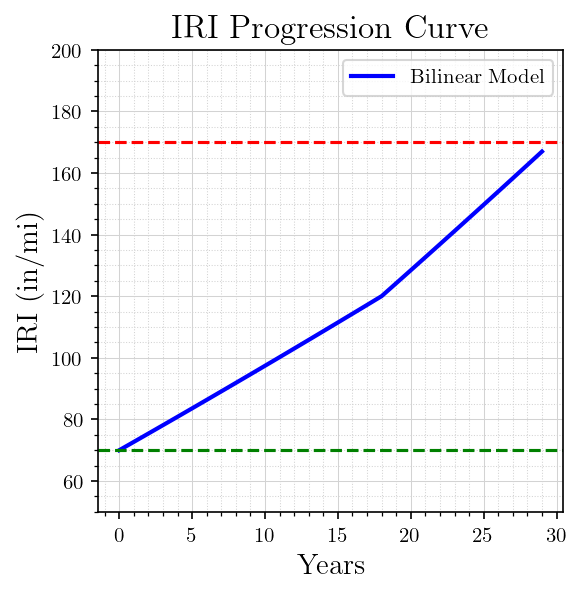

In [58]:
# IRI Progression Model
def calculate_bilinear_IRI(IRI_initial, Thickness, ESALs, a1, a2, b, c, threshold = 120):
    IRI = [IRI_initial]
    for ESAL in ESALs:
        if IRI[-1]<= threshold:
            IRI_next = IRI[-1] + a1 * (Thickness ** b) * (ESAL ** c)
        else:
            IRI_next = IRI[-1] + a2 * (Thickness ** b) * (ESAL ** c)
        IRI.append(IRI_next)
    return IRI

def IRI_Drop(m, n, IRI_before):
    return IRI_before - (m * IRI_before + n)

def objective_bilinear_function(params, IRI_initial, Thickness, ESALs, b, c):
    a1, a2 = params
    IRI_values = calculate_bilinear_IRI(IRI_initial, Thickness, ESALs, a1, a2, b, c)
    
    target_values = []
    for i, iri in enumerate(IRI_values):
        if iri <= 120:
            target_values.append(2.70 * i + IRI_initial)
        else:
            x_transition = (120 - IRI_initial) / 2.70
            b_intercept = 2.70 * x_transition + IRI_initial
            target_values.append(3.95 * i + b_intercept)
            
    return np.sum((np.array(IRI_values) - np.array(target_values)) ** 2)
            
def calculate_a1_a2(slope1, slope2, Thickness, b, c, ESAL_ref):
    a1 = slope1 / (Thickness ** b * (ESAL_ref ** c))
    a2 = slope2 / (Thickness ** b * (ESAL_ref ** c))
    
    return a1, a2
            
        
IRI_initial = 70.0  #initial IRI
IRI_end = 170.0     #final IRI
b = -0.6888
c = 0.1699
Thickness = 10 # inches
ESALs_yearly_normalized = np.array(ESALs_yearly[0:60])

slope1 = 2.70
slope2 = 3.95
ESAL_ref = ESALs_yearly_normalized[0]

# Calculate a1 and a2 based on the required slopes
a1_optimal, a2_optimal = calculate_a1_a2(slope1, slope2, Thickness, b, c, ESAL_ref)
print(f"Calculated values: a1 = {a1_optimal}, a2 = {a2_optimal}")

# Calculate the IRI progression with optimized a1 and a2
IRI_bilinear = calculate_bilinear_IRI(IRI_initial, Thickness, ESALs_yearly_normalized, a1_optimal, a2_optimal, b, c)
IRI_bilinear = np.array(IRI_bilinear)

filtered_IRI = [iri for iri in IRI_bilinear if iri <= IRI_end]
filtered_years = list(range(0, len(filtered_IRI)))

fig = plt.figure(figsize=(4, 4), dpi=150)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.plot(filtered_years, filtered_IRI, color='blue', linewidth=2.0, label='Bilinear Model')
plt.axhline(y=IRI_end, color='red', linestyle='--', linewidth=1.5)
plt.axhline(y=IRI_initial, color='green', linestyle='--', linewidth=1.5)

plt.xlabel('Years', fontsize = 14)
plt.ylabel('IRI (in/mi)', fontsize = 14)
plt.title('IRI Progression Curve', fontsize = 16)
plt.grid(color='lightgrey', linestyle='-', linewidth=0.50, zorder=0)
plt.minorticks_on()
plt.grid(which='minor', color='lightgrey', linestyle=':', linewidth=0.5)
plt.ylim([50, 200])
plt.legend()
plt.show()

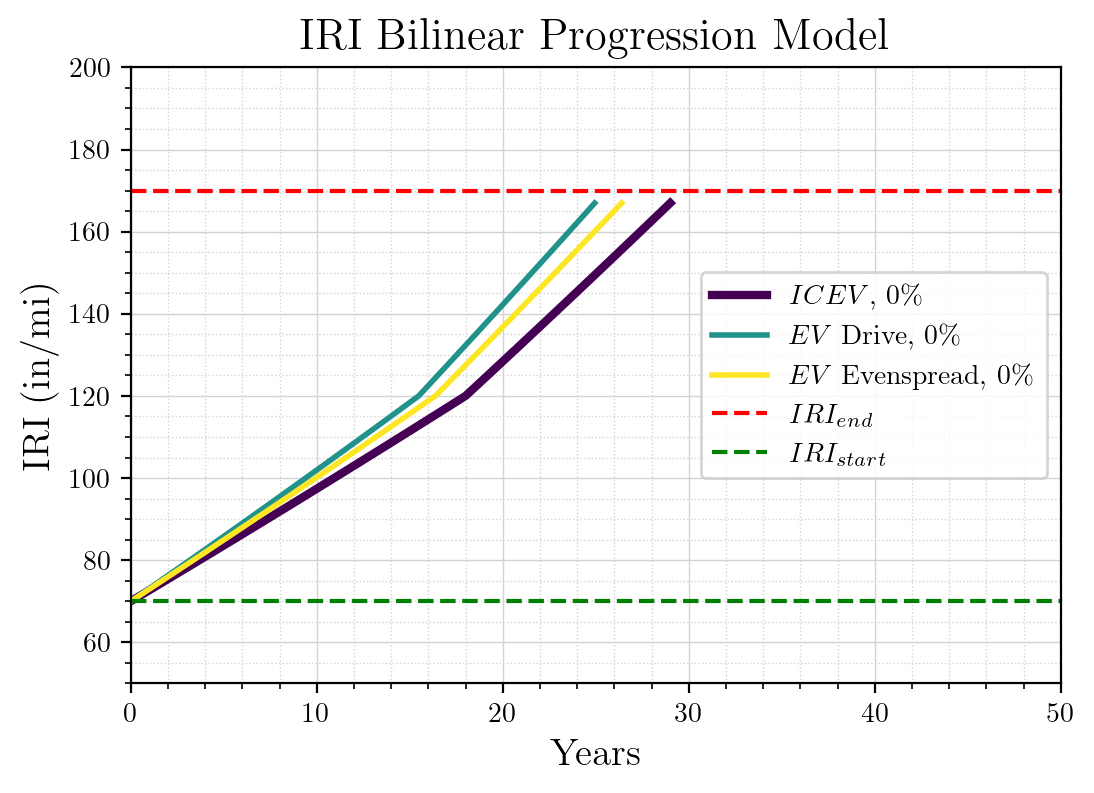

In [55]:
# Plot IRI progression curve
fig = plt.figure(figsize=(6, 4), dpi=200)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# create plot labels and linestyles
labels = ['$ICEV$, 0\\%', 
          '$EV$ Drive, 0\\%', 
          '$EV$ Evenspread, 0\\%']

colors = plt.cm.viridis(np.linspace(0, 1, len(scaling_values)))
linewidths = [3.0, 2.0, 2.0]
linestyles = ['-', '-', '-']

for i in range(len(scaling_values)):
    plt.plot(range(len(filtered_IRI))*scaling_values[i], filtered_IRI, label=labels[i], color = colors[i], linestyle=linestyles[i], linewidth = linewidths[i])

# Plot Label and Limits
plt.xlabel('Years', fontsize = 14)
plt.ylabel('IRI (in/mi)', fontsize = 14)
plt.axhline(y=IRI_end, color='red', linestyle='--', linewidth=1.5, label='$IRI_{end}$')
plt.axhline(y=IRI_initial, color='green', linestyle='--', linewidth=1.5, label='$IRI_{start}$ ')
plt.ylim(50, 200)
plt.xlim(0, 50)
plt.title('IRI Bilinear Progression Model', fontsize = 16)
plt.grid(color='lightgrey', linestyle='-', linewidth=0.50, zorder=0)
plt.minorticks_on()
plt.grid(which='minor', color='lightgrey', linestyle=':', linewidth='0.5')
plt.legend()
plt.show()

### **IRI Prediction (a)**

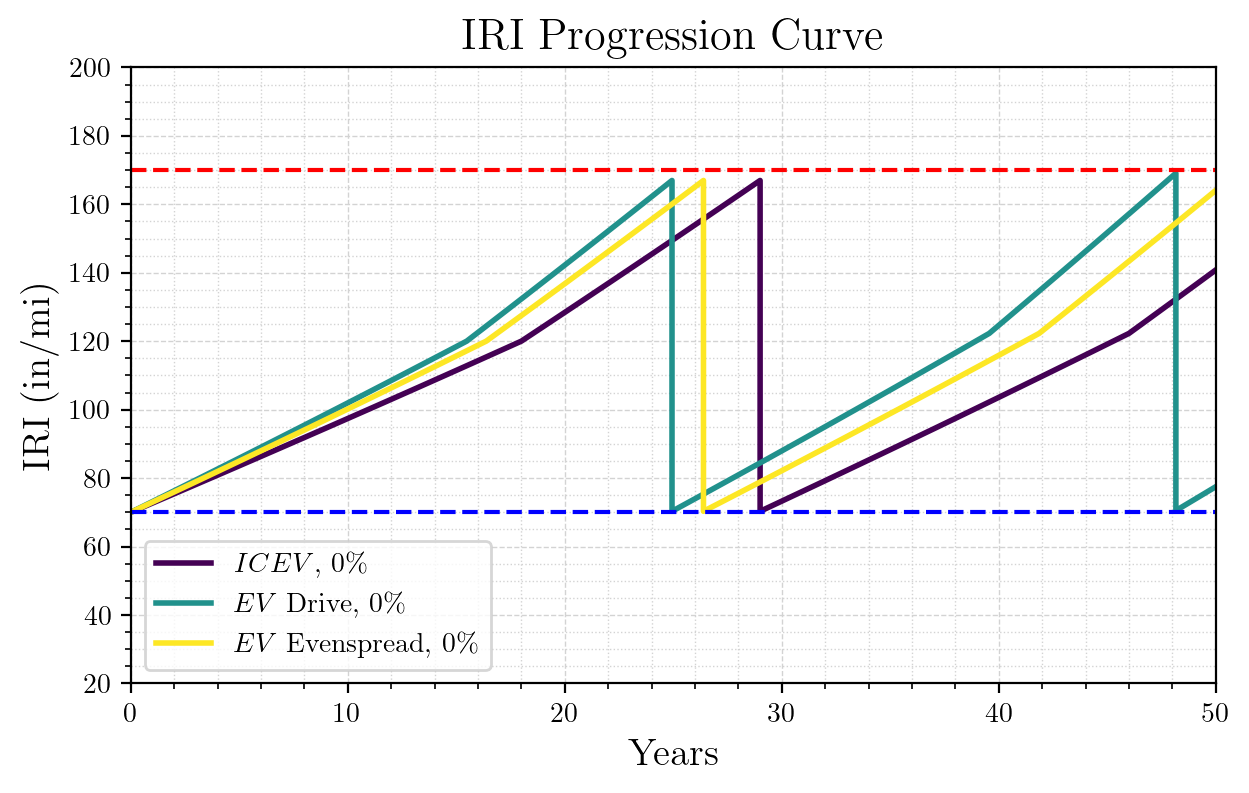

In [80]:
# Baseline Case
y_R = np.concatenate((np.arange(0, 30), [29], np.arange(30, 57), [56], np.arange(57, 60)))

IRI_P1 = calculate_bilinear_IRI(IRI_initial, Thickness, ESALs_yearly_normalized[0:29], a1_optimal, a2_optimal, b, c)
IRI_D1 = IRI_Drop(0.9037, -54.2114, IRI_P1[-1])
IRI_P2 = calculate_bilinear_IRI(IRI_D1, Thickness, ESALs_yearly_normalized[29:56], a1_optimal, a2_optimal, b, c)
IRI_D2 = IRI_Drop(0.9037, -54.2114, IRI_P2[-1])
IRI_P3 = calculate_bilinear_IRI(IRI_D2, Thickness, ESALs_yearly_normalized[56:59], a1_optimal, a2_optimal, b, c)
IRI_D3 = IRI_Drop(0.9037, -54.2114, IRI_P3[-1])

# EV-Drive Axle
y_D = y_R*scaling_values[1]

# EV-Evenspread
y_E = y_R*scaling_values[2]

# concatenate IRI progression
IRI_R = IRI_P1 + IRI_P2 + IRI_P3

# Plot IRI progression curve
fig = plt.figure(figsize=(7, 4), dpi=200)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.plot(y_R , IRI_R, color=colors[0], linewidth=2.0, label = '$ICEV$, 0\\%')
plt.plot(y_D , IRI_R, color=colors[1], linewidth=2.0, label = '$EV$ Drive, 0\\%')
plt.plot(y_E , IRI_R, color=colors[2], linewidth=2.0, label = '$EV$ Evenspread, 0\\%')

plt.axhline(y=IRI_end, color='red', linestyle='--', linewidth=1.5)
plt.axhline(y=IRI_initial, color='blue', linestyle='--', linewidth=1.5)
plt.xlabel('Years', fontsize = 14)
plt.ylabel('IRI (in/mi)', fontsize = 14)
plt.ylim(20, 200)
plt.xlim(0, 50)
plt.title('IRI Progression Curve', fontsize = 16, fontweight='bold')
plt.grid(color='lightgrey', linestyle='--', linewidth=0.50, zorder=0)
plt.legend(loc='lower left')


plt.minorticks_on()
plt.grid(which='minor', color='lightgrey', linestyle=':', linewidth='0.5')
plt.show()